In [1]:
import numpy as np 
import pandas as pd 

import math
import random 
import os 
import cv2
import timm
import time

from tqdm import tqdm 

import albumentations as A 
from albumentations.pytorch.transforms import ToTensorV2

import torch 
from torch.utils.data import Dataset 
from torch import nn
import torch.nn.functional as F 

import matplotlib.pyplot as plt
import plotly.express as px
from urllib.request import urlopen
from PIL import Image
import io
import gc
import requests
from numpy import dot
from numpy.linalg import norm
import json
import pymysql
#from scipy.spatial import distance

In [2]:
def selectUserCloset(accountId):
        conn = pymysql.connect(host='wearly-appservice.cnckmwivf8yh.ap-northeast-2.rds.amazonaws.com', user='wearly', password='fashionai19!', db='wearly_appservice_dev', charset='utf8')
        curs = conn.cursor()
        try:
            curs = conn.cursor()
            sql = """select image_url, a.id,  name
                     from (select a.id, a.image_url, a.name
                     from AiDetection a, AiDetection_color b
                     where a.id = b.AiDetection_id
                     group by a.id, a.image_url, a.name, a.styleMain, a.styleSub) a, (select AiDetection.id
                     from AiDetection inner Join Account on AiDetection.account_id = Account.id
                     where account_id = '""" + accountId + """') b
                     where a.id = b.id;"""
            curs.execute(sql)
            result = curs.fetchall()
        finally:
            conn.close()

        return result

In [17]:
class Config:
    META_CSV = '/mnt/hdd1/wearly/deep_rec/separ_meta.csv'
    
    DATA_DIR = '/mnt/hdd1/wearly/compatibility_rec/data/images'
    TRAIN_EMB = '/mnt/hdd1/wearly/deep_rec/traindata_embeddings.npy'
    SEED = 123

    IMG_SIZE = 224
    MEAN = [0.485, 0.456, 0.406]
    STD = [0.229, 0.224, 0.225]

    BATCH_SIZE = 1
    N_FOLDS = 5
    FC_DIM = 512
    
    NUM_WORKERS = 4
    DEVICE = 'cuda:1'
     
    CLASSES = 3672
    SCALE = 30 
    MARGIN = 0.5

    MODEL_NAME = 'tf_efficientnet_b4'
    MODEL_PATH = './separ_tf_efficientnet_b4_30_Weights/separ_tf_efficientnet_b4_2EpochStep_adam.pt'
    


In [18]:
def read_dataset():
    df = pd.read_csv(Config.TRAIN_CSV,index_col=0)
    image_paths = Config.DATA_DIR + '/' + df['image_name']
    return df,image_paths

def seed_setting(seed=Config.SEED):
    random.seed(seed)
    torch.cuda.set_device(Config.DEVICE)
#     set_seed(seed, reproducible=True)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True
    
seed_setting(Config.SEED)

In [19]:
class KfashionDataset(Dataset):
    def __init__(self, image_url, transforms=None):

        self.image_url = image_url
        self.augmentations = transforms

    def __len__(self):
        return self.image_url.shape[0]

    def __getitem__(self, index):
        image_url = self.image_url[index]
        
        dt = urlopen(image_url)
        usr_img = Image.open(io.BytesIO(dt.read())).convert("RGB")
        usr_img = np.asarray(usr_img)
        image = torch.tensor(np.asarray(usr_img)).float()
        
        #image = cv2.imread(image_url)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.augmentations:
            augmented = self.augmentations(image=image)
            image = augmented['image']       
    
        return image, torch.tensor(1)

In [20]:
def get_test_transforms():

    return A.Compose(
        [
            A.Resize(Config.IMG_SIZE, Config.IMG_SIZE,always_apply=True),
            A.Normalize(),
        ToTensorV2(p=1.0)
        ]
    )

In [21]:
class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features, scale=30.0, margin=0.50, easy_margin=False, ls_eps=0.0):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.scale = scale
        self.margin = margin
        self.ls_eps = ls_eps  # label smoothing
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(margin)
        self.sin_m = math.sin(margin)
        self.th = math.cos(math.pi - margin)
        self.mm = math.sin(math.pi - margin) * margin

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device=Config.DEVICE)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.scale

        return output, nn.CrossEntropyLoss()(output,label)

class KfashionModel(nn.Module):

    def __init__(
        self,
        n_classes = Config.CLASSES,
        model_name = Config.MODEL_NAME,
        margin = Config.MARGIN,
        fc_dim = Config.FC_DIM,
        scale = Config.SCALE,
        use_fc = True,
        pretrained = True):


        super(KfashionModel,self).__init__()
        print('Building Model Backbone for {} model'.format(model_name))

        self.backbone = timm.create_model(model_name, pretrained=pretrained)

        if model_name == 'resnext50_32x4d':
            final_in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
            self.backbone.global_pool = nn.Identity()

        elif 'efficientnet' in model_name:
            final_in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()
            self.backbone.global_pool = nn.Identity()
        
        elif 'nfnet' in model_name:
            final_in_features = self.backbone.head.fc.in_features
            self.backbone.head.fc = nn.Identity()
            self.backbone.head.global_pool = nn.Identity()

        self.pooling =  nn.AdaptiveAvgPool2d(1)

        self.use_fc = use_fc

        if use_fc:
            self.dropout = nn.Dropout(p=0.0)
            self.fc = nn.Linear(final_in_features, fc_dim)
            self.bn = nn.BatchNorm1d(fc_dim)
            self._init_params()
            final_in_features = fc_dim

        self.final = ArcMarginProduct(
            final_in_features,
            n_classes,
            scale = scale,
            margin = margin,
            easy_margin = False,
            ls_eps = 0.0
        )

    def _init_params(self):
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0)
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)

    def forward(self, image):
        feature = self.extract_feat(image)
        #logits = self.final(feature,label)
        return feature

    def extract_feat(self, x):
        batch_size = x.shape[0]
        x = self.backbone(x)
        x = self.pooling(x).view(batch_size, -1)

        if self.use_fc:
            x = self.dropout(x)
            x = self.fc(x)
            x = self.bn(x)
        return x

In [22]:
def get_image_embeddings(img_url, model_name = Config.MODEL_NAME):
    embeds = []
    
    model = KfashionModel(model_name = model_name)
    model.eval()
    
    if model_name == 'eca_nfnet_l0':
        model = replace_activations(model, torch.nn.SiLU, Mish())

    model.load_state_dict(torch.load(Config.MODEL_PATH))
    model = model.to(Config.DEVICE)
    
    
    #dt = urlopen(img_url)
    #usr_img = Image.open(io.BytesIO(dt.read())).convert("RGB")
    
    image_nparray = np.asarray(bytearray(requests.get(img_url).content), dtype=np.uint8)
    image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR)
    
    #image = cv2.imread(dt)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    aug = get_test_transforms()
    augmented = aug(image=image)
    img = augmented['image']
    img = img.unsqueeze(0).float()  # if torch tensor
    
    with torch.no_grad():
        img = img.cuda()
        feat = model(img)
        image_embeddings = feat.detach().cpu().numpy()
        embeds.append(image_embeddings)
    
    
    del model
    image_embeddings = np.concatenate(embeds)
    del embeds
    gc.collect()
    return image_embeddings

In [23]:
def get_image_predictions(user_embeddings, train_embs,image_name_emb, threshold):
    
    start = time.time()
    
    # https://gritmind.blog/2020/06/21/diff_similarity_distance/
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html
    # https://goofcode.github.io/similarity-measure
    # https://www.delftstack.com/ko/howto/python/cosine-similarity-between-lists-python/
    preds = {i: 1- (dot(user_embeddings, vec_b)/(norm(user_embeddings)*norm(vec_b)))[0]
             for i, vec_b in tqdm(enumerate(train_embs))}
    #preds2 = {i : distance.cosine(user_embeddings, vec_b) for i, vec_b in tqdm(enumerate(train_embs))}
    #print(preds2)
    
    preds = dict(sorted(preds.items(), key = lambda item: item[1]
                        #, reverse = True
                       )[:10])    
    
    print("NearestNeighbors Running time :", time.time() - start)
    
    distances = np.array(list(preds.values()))
    indices = np.array(list(preds.keys()))
    predictions = []

    idx = np.where(distances < threshold)[0]
    ids = indices[idx]
    posting_ids = list(image_name_emb['image_name'].iloc[ids])
    predictions.append(posting_ids)
    
    gc.collect()
    
    
    
    
    return predictions

In [24]:
def get_other_imgembeddings():
    train_embs = np.load('traindata_embeddings.npy')
    train_path_emb = np.load('traindata_embeddings_path.npy',allow_pickle=True)
    
    train_path_embeddings = train_path_emb.tolist()
    
    return train_embs, train_path_embeddings

# def get_other_imgembeddings(user_embeddings):
#     train_embs = np.load('traindata_embeddings.npy')
#     print(train_embs.shape)
#     train_path_emb = np.load('traindata_embeddings_path.npy',allow_pickle=True)
    
#     image_embeddings = np.insert(train_embs,0,user_embeddings, axis=0)
#     train_path_embeddings = np.insert(train_path_emb,0,"https://thumbnail.10x10.co.kr/webimage/image/basic600/368/B003684850.jpg", axis=0)
#     train_path_embeddings = train_path_embeddings.tolist()
    
#     return image_embeddings, train_path_embeddings

In [25]:
class visual_kfashion:
    def visualize(url, pred, matrix_num):
        smp_dt = pred[1:]
        
        fig = plt.figure(figsize=(20, 20))
        rows = matrix_num
        cols = matrix_num
        i = 1
        
        dt = urlopen(url)
        usr_img = Image.open(io.BytesIO(dt.read())).convert("RGB")
        display(usr_img)
        
        for filename in smp_dt:
            try:
                plt.rcParams["font.family"] = 'NanumGothicCoding'
                img = cv2.imread(f'{filename}')
                ax = fig.add_subplot(rows, cols, i)
                ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                
                ax.set_xlabel(f" {filename}")
                ax.set_xticks([]), ax.set_yticks([])
                i += 1
            except:
                break

In [26]:
def run(url):
    user_embeddings = get_image_embeddings(img_url=url)
    
    train_embeddings, train_path_embeddings = get_other_imgembeddings()
    train_path_embeddings = pd.DataFrame(train_path_embeddings, columns=['image_name'])
    
    image_pred = get_image_predictions(user_embeddings, train_embeddings,train_path_embeddings, 0.7)
    image_pred_dict = {url : image_pred[0][:10]} 
    image_pred_dict = json.dumps(image_pred_dict, indent=4, ensure_ascii = False)
    
    print('---'*30)
    print(image_pred_dict)
    return image_pred

In [27]:
# pred_group = run("https://thumbnail.10x10.co.kr/webimage/image/basic600/368/B003684850.jpg")

In [28]:
# url = "https://thumbnail.10x10.co.kr/webimage/image/basic600/368/B003684850.jpg"
# path = '/mnt/hdd1/wearly/aim_code/yolov5/data/kfashion/images/all'
# visual_kfashion.visualize(url=url, pred=pred_group[0], matrix_num=4)

# Aws DB 

In [29]:
userID = '87166e29-ede7-468d-9a9c-570fede03bfe'
aws_closet = selectUserCloset(userID)
userSelect = aws_closet[4][0] # [0][0] [1][0] [2][0] ....

In [30]:
pred_group=run(userSelect)

Building Model Backbone for tf_efficientnet_b4 model


889128it [00:09, 93695.25it/s]


NearestNeighbors Running time : 9.610168933868408
------------------------------------------------------------------------------------------
{
    "https://wearly-ml-storage.s3.ap-northeast-2.amazonaws.com/static/images/87166e29-ede7-468d-9a9c-570fede03bfe/20210901/1630505798080_knitwear.jpg": []
}


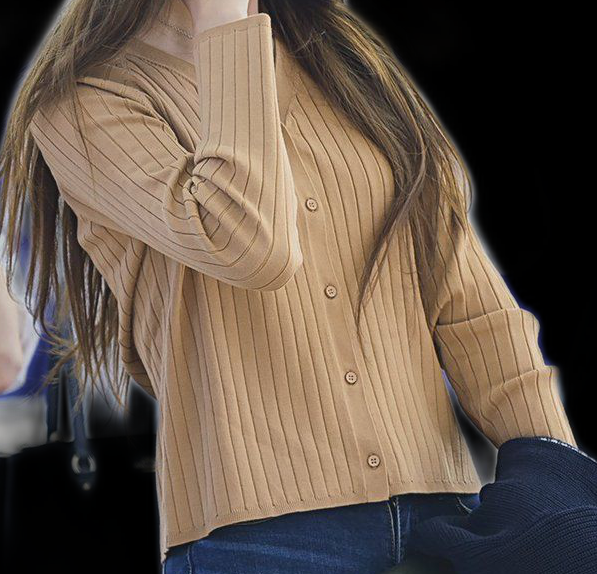

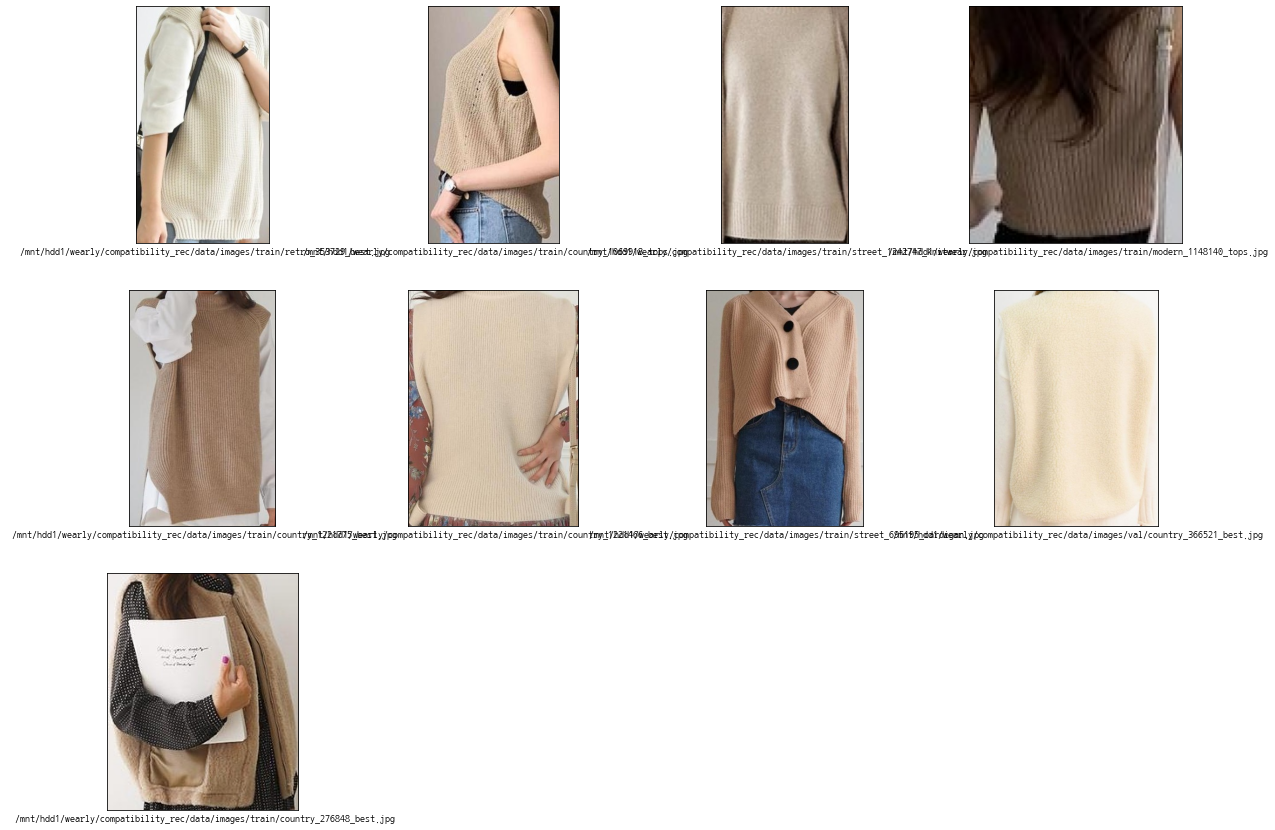

In [34]:
path = '/mnt/hdd1/wearly/aim_code/yolov5/data/kfashion/images/all'
visual_kfashion.visualize(url=userSelect, pred=pred_group[0], matrix_num=4)

Building Model Backbone for tf_efficientnet_b3 model


300000it [00:03, 91571.00it/s]


NearestNeighbors Running time : 3.4649384021759033
------------------------------------------------------------------------------------------
{
    "https://wearly-ml-storage.s3.ap-northeast-2.amazonaws.com/static/images/87166e29-ede7-468d-9a9c-570fede03bfe/20210829/1630232033243_blouse.jpeg": [
        "/mnt/hdd1/wearly/compatibility_rec/data/images/train/feminine_878692_blouse.jpg",
        "/mnt/hdd1/wearly/compatibility_rec/data/images/train/feminine_878828_blouse.jpg",
        "/mnt/hdd1/wearly/compatibility_rec/data/images/train/sophisticated_1338970_blouse.jpg",
        "/mnt/hdd1/wearly/compatibility_rec/data/images/train/resort_1341704_blouse.jpg",
        "/mnt/hdd1/wearly/compatibility_rec/data/images/train/country_322328_blouse.jpg",
        "/mnt/hdd1/wearly/compatibility_rec/data/images/train/romantic_481884_blouse.jpg",
        "/mnt/hdd1/wearly/compatibility_rec/data/images/train/romantic_481722_blouse.jpg",
        "/mnt/hdd1/wearly/compatibility_rec/data/images/train/

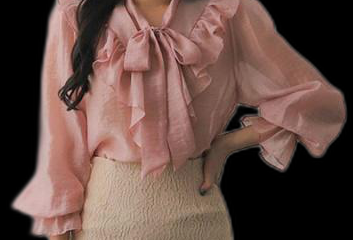

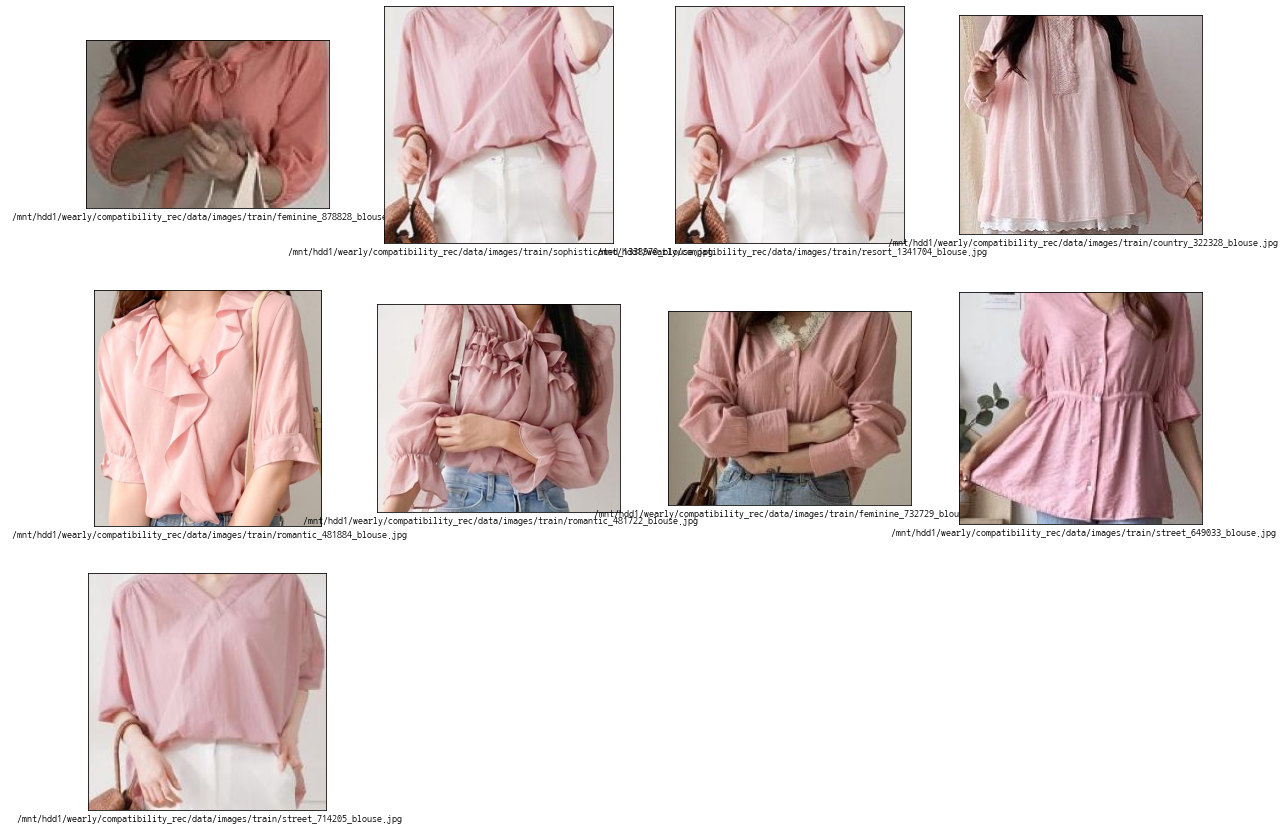

In [35]:
userID = '87166e29-ede7-468d-9a9c-570fede03bfe'
aws_closet = selectUserCloset(userID)
userSelect = aws_closet[0][0] # [0][0] [1][0] [2][0] ....

pred_group=run(userSelect)
path = '/mnt/hdd1/wearly/aim_code/yolov5/data/kfashion/images/all'
visual_kfashion.visualize(url=userSelect, pred=pred_group[0], matrix_num=4)

Building Model Backbone for tf_efficientnet_b3 model


300000it [00:03, 87888.74it/s]


NearestNeighbors Running time : 3.5961124897003174
------------------------------------------------------------------------------------------
{
    "https://wearly-ml-storage.s3.ap-northeast-2.amazonaws.com/static/images/87166e29-ede7-468d-9a9c-570fede03bfe/20210901/1630505829737_t-shirt.jpg": [
        "/mnt/hdd1/wearly/compatibility_rec/data/images/train/feminine_927459_t-shirt.jpg",
        "/mnt/hdd1/wearly/compatibility_rec/data/images/train/feminine_929162_t-shirt.jpg",
        "/mnt/hdd1/wearly/compatibility_rec/data/images/train/street_1198497_t-shirt.jpg",
        "/mnt/hdd1/wearly/compatibility_rec/data/images/val/feminine_929155_t-shirt.jpg",
        "/mnt/hdd1/wearly/compatibility_rec/data/images/train/romantic_1122560_blouse.jpg",
        "/mnt/hdd1/wearly/compatibility_rec/data/images/train/resort_309123_knitwear.jpg",
        "/mnt/hdd1/wearly/compatibility_rec/data/images/train/street_1198493_t-shirt.jpg",
        "/mnt/hdd1/wearly/compatibility_rec/data/images/val/stre

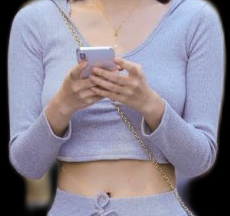

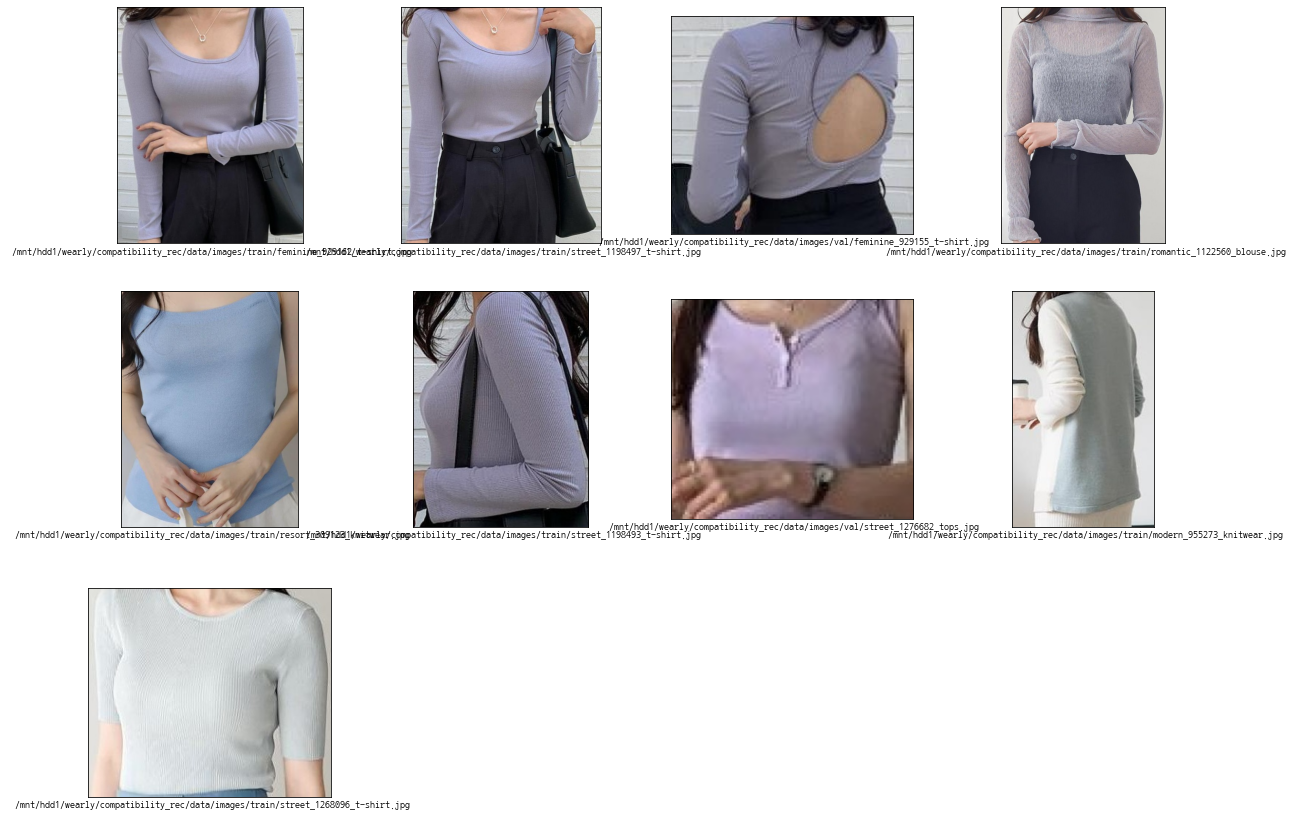

In [36]:
userID = '87166e29-ede7-468d-9a9c-570fede03bfe'
aws_closet = selectUserCloset(userID)
userSelect = aws_closet[7][0] # [0][0] [1][0] [2][0] ....

pred_group=run(userSelect)
path = '/mnt/hdd1/wearly/aim_code/yolov5/data/kfashion/images/all'
visual_kfashion.visualize(url=userSelect, pred=pred_group[0], matrix_num=4)

Building Model Backbone for tf_efficientnet_b3 model


300000it [00:03, 88149.33it/s]


NearestNeighbors Running time : 3.5881078243255615
------------------------------------------------------------------------------------------
{
    "https://wearly-ml-storage.s3.ap-northeast-2.amazonaws.com/static/images/87166e29-ede7-468d-9a9c-570fede03bfe/20210901/1630505798080_jean.jpg": [
        "/mnt/hdd1/wearly/compatibility_rec/data/images/train/street_811518_jean.jpg",
        "/mnt/hdd1/wearly/compatibility_rec/data/images/train/street_701883_jean.jpg",
        "/mnt/hdd1/wearly/compatibility_rec/data/images/train/oriental_593798_jean.jpg",
        "/mnt/hdd1/wearly/compatibility_rec/data/images/train/classic_978369_jean.jpg",
        "/mnt/hdd1/wearly/compatibility_rec/data/images/train/street_23393_jean.jpg",
        "/mnt/hdd1/wearly/compatibility_rec/data/images/train/street_319308_jean.jpg",
        "/mnt/hdd1/wearly/compatibility_rec/data/images/train/modern_961610_jean.jpg",
        "/mnt/hdd1/wearly/compatibility_rec/data/images/train/street_350845_jean.jpg",
        

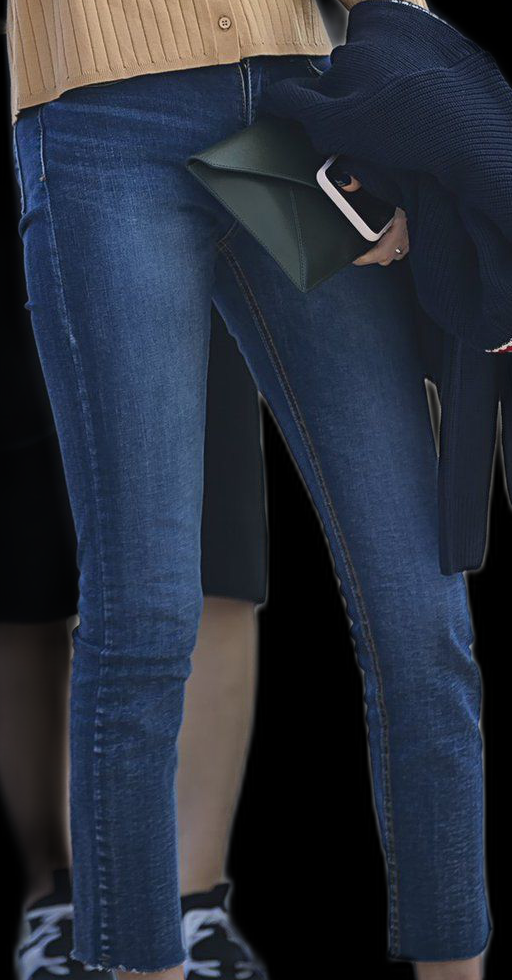

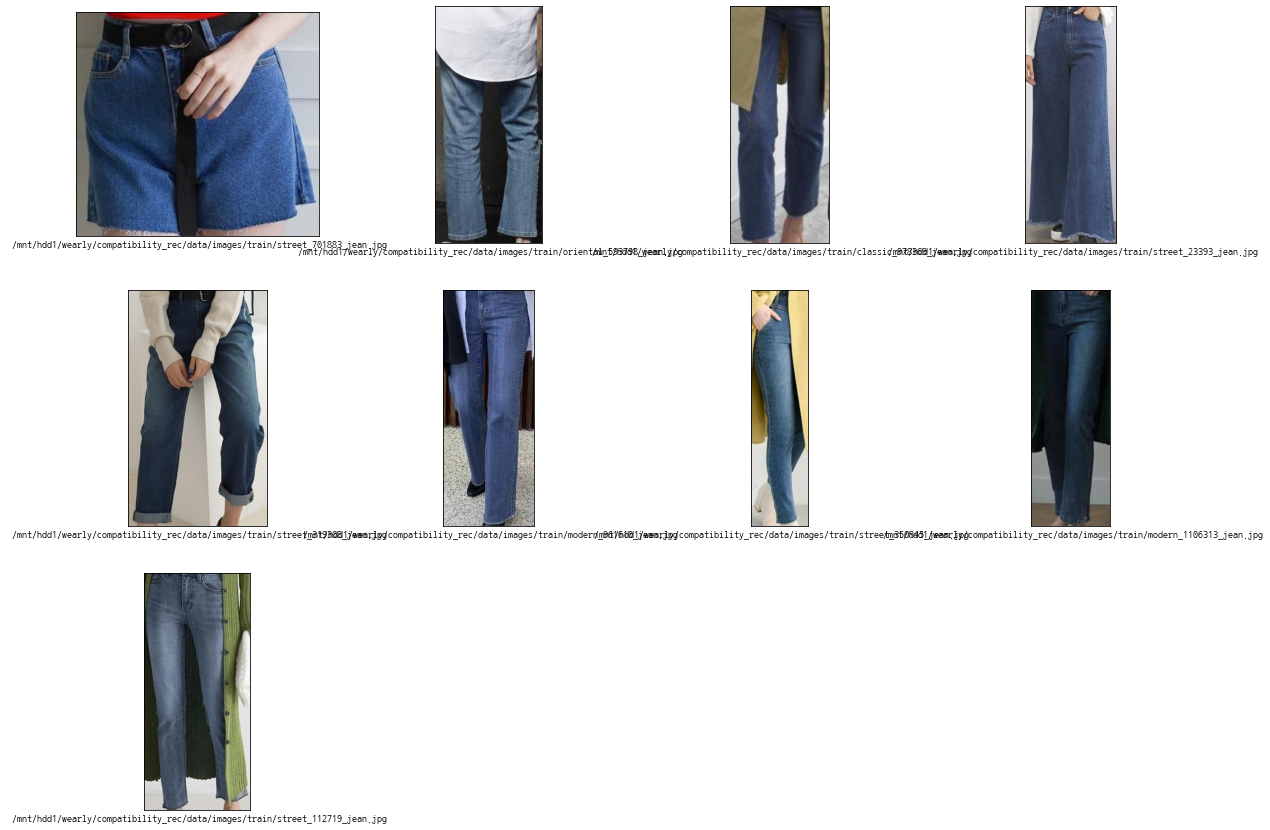

In [37]:
userID = '87166e29-ede7-468d-9a9c-570fede03bfe'
aws_closet = selectUserCloset(userID)
userSelect = aws_closet[5][0] # [0][0] [1][0] [2][0] ....

pred_group=run(userSelect)
path = '/mnt/hdd1/wearly/aim_code/yolov5/data/kfashion/images/all'
visual_kfashion.visualize(url=userSelect, pred=pred_group[0], matrix_num=4)